Load libraries and data.

In [139]:
import numpy as np
import matplotlib.pyplot as plt

train=np.loadtxt('sincTrain25.dt')
trainx=train[:,0]
trainy=train[:,1]
valid=np.loadtxt('sincValidate10.dt')
valx=valid[:,0]
valy=valid[:,1]

Let's plot the training data and validation data (they are generated from the function sinc(x)=sin(x)/x)so we have an idea of what it looks like.

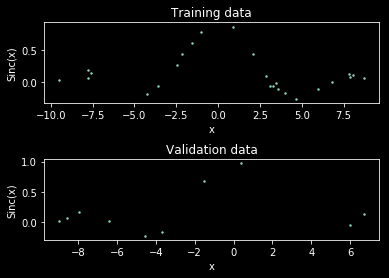

In [140]:
%matplotlib inline
plt.style.use("dark_background")
fig, ax = plt.subplots(2)
fig.subplots_adjust(hspace=0.7)
ax[0].scatter(trainx, trainy, s=2)
ax[0].set_title('Training data')
ax[0].set_ylabel('Sinc(x)')
ax[0].set_xlabel('x')
ax[1].scatter(valx, valy, s=2)
ax[1].set_title('Validation data')
ax[1].set_ylabel('Sinc(x)')
ax[1].set_xlabel('x')
plt.show()

Define neural network function and gradient descent function

In [141]:
def neural_network(x, w, activation_function, has_ones = False):
    w0 = w[0]
    w1 = w[1]
    if len(x.shape)<1:
        x = x.reshape(1,1)
    N = x.shape[0]
    if not has_ones:
        x = np.c_[np.ones(N), x]
    a = x@w0 # dimenson is d*M where M is number of columns in w0, i.e. number of neurons
    if activation_function == 'relu':
        z = relu(a)
    elif activation_function == 'softsign':
        z = a/(1+np.abs(a))
    z = np.c_[np.ones(z.shape[0]), z] # ones for bias
    out = z@w1
    return(dict(first_mult = a, first_mult_nonlin = z, second_mult = out))

def relu(x):
    zeroes = np.zeros(x.shape)
    zeroes[x>0] = x[x>0]
    return(zeroes)

def relu_grad(x):
    grad = (x > 0)*1
    return(grad)

def nn_grad(x, y, a, z, out, w, activation_function):
    '''y must be an array of dimension at least 2'''
    w_out = w[1]
    N = x.shape[0]
    delta_outs = out-y # N*1
    qq = np.zeros(21)
    delta_outs_repeated = np.repeat((out-y), w_out.shape[0], axis=1) # N*(n_hidden+1)
    output_grad = np.sum(np.multiply(delta_outs, z), axis=0)/N # gradient of output unit
    if len(output_grad.shape)<2:
        output_grad = output_grad.reshape(output_grad.shape[0], 1)
    if activation_function == 'relu':
        hidden_activation_deriv = relu_grad(a)
    elif activation_function == 'softsign':
        hidden_activation_deriv = 1/((1+np.abs(a))**2)
    delta_hidden_sum_parts = delta_outs@w_out.T # this must be a sum with more than 1 output neuron
    delta_hidden_sum_parts = delta_hidden_sum_parts[:,1:] # removing bias column
    delta_hidden = hidden_activation_deriv*delta_hidden_sum_parts
    hidden_grad = 0
    for i in range(N):
        vector_of_deltas = delta_hidden[i,:]
        vector_of_deltas = vector_of_deltas.reshape(a.shape[1],1)
        grad_element = x[i,:]*vector_of_deltas
        hidden_grad += grad_element/N
    return([hidden_grad.T, output_grad])

def nn_gradient_descent(x_train, y_train, x_val, y_val, n_hidden, rate, iterations, patience,
                       verbose, weights, initialization_factors, activation_function):
    if len(y_train.shape)==1:
        y_train = y_train.reshape(y_train.shape[0], 1)
    if len(y_val.shape)==1:
        y_val = y_val.reshape(y_val.shape[0], 1)
    if len(x_train.shape)==1:
        x_train = x_train.reshape(x_train.shape[0], 1)
    K = y_train.shape[1]
    D = x_train.shape[1]
    N = x_train.shape[0]
    x_train = np.c_[np.ones(N), x_train, ]
    # initialize weights
    if initialization_factors == None:
        initialization_factors = [np.sqrt(2/(D+1 + n_hidden)), np.sqrt(2/(n_hidden+1 + K))]
    if weights == None:
        w_hidden0 = np.random.normal(0, 1, (D+1, n_hidden)) * initialization_factors[0]
        w_out0 = np.random.normal(0, 1, (n_hidden+1, K)) * initialization_factors[1]
    w_hidden1 = None
    w_out1 = None
    w_best = None
    
    patience_counter = patience
    train_loss = []
    val_loss = []
    gradient_norm = []
    max_iter = iterations
    while iterations > 0 and patience_counter >0:
        w=[w_hidden0, w_out0]
        nn_outs_train = neural_network(x_train, w, activation_function, has_ones=True)
        a = nn_outs_train['first_mult']
        z = nn_outs_train['first_mult_nonlin']
        out = nn_outs_train['second_mult']
        train_error = 0.5*np.sum((y_train - out)**2)/N
        if len(out.shape)<2:
            out=out.reshape(y_train.shape[0], 1) # reshaping to get broadcasting to work later
        train_loss.append(train_error)
        delta_outs = (out-y_train) # N*1
        grads = nn_grad(x=x_train, y=y_train, a=a, z=z, out=out, w=w, activation_function=activation_function)
        hidden_grad = grads[0]
        output_grad = grads[1]
        w_hidden1 = w_hidden0 - rate*hidden_grad #/N
        w_out1 = w_out0 - rate*output_grad #/N
        val_out = neural_network(x_val, w, activation_function=activation_function)['second_mult']
        val_error = 0.5*np.sum((y_val - val_out)**2)/x_val.shape[0]
        iterations -= 1
        if verbose: 
            print('iterations: ', max_iter-iterations)
            print('Training loss: {}, Validation loss: {}'.format(train_error, val_error))
        if len(val_loss)>1:
            if val_error < min(val_loss):
                if verbose: 
                    print('new best w')
                w_best = w
                patience_counter = patience
            elif val_error >= val_loss[-1]:
                patience_counter -= 1
        val_loss.append(val_error)
        w_out0 = w_out1
        w_hidden0 = w_hidden1
        gradient_norm_i = np.sqrt(np.sum(np.concatenate([w_hidden0.flatten(), w_out0.flatten()])**2))
        gradient_norm.append(gradient_norm_i)
    if w_best == None:
        w_best = [w_hidden0, w_out0]
    return(dict(weights=w_best, train_loss=train_loss, val_loss=val_loss, gradient_norm=gradient_norm,
               iterations=max_iter-iterations))


Put the things into a class.

In [142]:
class NNregressor_onelayer:
    def __init__(self, activation_function, weights=None):
        self.weights = weights
        self.activation_function = activation_function
    def estimate_weights(self, trainx, trainy, valx, valy, n_hidden, rate, iterations, patience, verbose,
                        weight_initialization_factors):
        training_results = nn_gradient_descent(trainx, trainy, valx, valy, n_hidden, 
                                           rate, iterations, patience, verbose,
                                           self.weights, weight_initialization_factors,
                                               activation_function = self.activation_function)
        self.weights = training_results['weights']
        self.training_loss = training_results['train_loss']
        self.validation_loss = training_results['val_loss']
        self.gradient_norm = training_results['gradient_norm']
        self.iterations = training_results['iterations']
    def predict(self, x):
        predictions = neural_network(x, self.weights, activation_function = self.activation_function)
        return(predictions['second_mult'].ravel())

First we need to validate the gradient. We make up some random weights and calculate some outputs.

In [143]:
np.random.seed(84)
wtest1=np.random.normal(0,1,(2,20))
wtest2=np.random.normal(0,1,(21,1))
test_out=neural_network(trainx,[wtest1,wtest2], 'relu')
test_a = test_out['first_mult']
test_z = test_out['first_mult_nonlin']
test_pred = test_out['second_mult']
test_error = 0.5*np.sum((test_pred - trainy.reshape(trainy.shape[0], 1))**2)/25
test_grad = nn_grad(np.c_[np.ones(25), trainx.reshape(25,1)], trainy.reshape(25,1), 
                    test_a, test_z, test_pred, [wtest1, wtest2], 'relu')
test_error

173.37861170911933

We use a bunch of for loops to check the gradients.

In [144]:
error_grad_out_all = np.zeros((21,1))
error_grad_hidden_all = np.zeros((2, 20))
for n in range(25):
    eps_val = np.sqrt(np.finfo(float).eps)
    error_grad_out = []
    for i in range(wtest2.shape[0]):
        for j in range(wtest2.shape[1]):
            wtest2_2 = np.copy(wtest2)
            wtest2_2[i,j] = wtest2_2[i, j] + eps_val
            pred_noneps = neural_network(trainx[n], [wtest1, wtest2], 'relu')['second_mult'].reshape(1,1)
            pred_eps = neural_network(trainx[n], [wtest1, wtest2_2], 'relu')['second_mult'].reshape(1,1)
            error_noneps = 0.5*(pred_noneps-trainy[n])**2
            error_eps = 0.5*(pred_eps-trainy[n])**2
            error_grad_ij = (error_eps-error_noneps)/eps_val
            error_grad_out.append(error_grad_ij)
    error_grad_hidden = []
    for i in range(wtest1.shape[0]):
        for j in range(wtest1.shape[1]):
            wtest1_2 = np.copy(wtest1)
            wtest1_2[i,j] = wtest1_2[i, j] + eps_val
            pred_noneps = neural_network(trainx[n], [wtest1, wtest2], 'relu')['second_mult'].reshape(1,1)
            pred_eps = neural_network(trainx[n], [wtest1_2, wtest2], 'relu')['second_mult'].reshape(1,1)
            error_noneps = 0.5*(pred_noneps-trainy[n])**2
            error_eps = 0.5*(pred_eps-trainy[n])**2
            error_grad_ij = (error_eps-error_noneps)/eps_val
            error_grad_hidden.append(error_grad_ij)
    error_grad_hidden_all+=(np.array(error_grad_hidden).reshape(2,20))/25
    error_grad_out_all+=np.array(error_grad_out).reshape(21,1)/25

In [145]:
(test_grad[0]+np.finfo(float).eps)/(error_grad_hidden_all+np.finfo(float).eps)

array([[1.00000021, 1.00000008, 1.00000001, 1.00000011, 1.        ,
        0.9999999 , 0.99999983, 0.99999999, 1.00000001, 1.00000515,
        0.99999986, 1.        , 0.99999937, 0.9999999 , 1.00000002,
        0.99999977, 0.99999993, 0.99999998, 1.        , 1.00000002],
       [0.99999993, 0.99999997, 1.        , 0.99999998, 1.        ,
        1.00000001, 1.00000001, 1.00000001, 0.99999999, 0.99999943,
        1.00000002, 0.99999998, 1.00000014, 1.00000002, 1.        ,
        1.00000006, 0.99999999, 1.00000001, 1.        , 1.        ]])

In [146]:
((test_grad[1]+np.finfo(float).eps)/(error_grad_out_all+np.finfo(float).eps)).T

array([[0.99999999, 1.00000001, 1.00000003, 0.99999999, 1.00000008,
        1.        , 1.        , 1.00000001, 1.00000003, 0.99999999,
        1.00000002, 1.00000002, 1.00000001, 1.00000001, 1.00000001,
        0.99999999, 0.99999997, 1.        , 0.99999999, 1.00000001,
        1.        ]])

Gradient checks out. Let's make a model and train it.

In [147]:
mlp_sinc = NNregressor_onelayer(activation_function = 'relu')
mlp_sinc.estimate_weights(trainx, trainy, valx, valy, n_hidden=100, 
                              iterations=10000, patience=20, rate=0.05, 
                              verbose=True, weight_initialization_factors=[0.1, 0.1])

iterations:  1
Training loss: 0.11935339825862956, Validation loss: 0.23002532007794446
iterations:  2
Training loss: 0.0516400775430421, Validation loss: 0.09760446732779782
iterations:  3
Training loss: 0.04700884118202189, Validation loss: 0.08086725557605871
new best w
iterations:  4
Training loss: 0.04591573940921677, Validation loss: 0.07682663757784478
new best w
iterations:  5
Training loss: 0.04515548653065247, Validation loss: 0.07507783955707727
new best w
iterations:  6
Training loss: 0.04445453186031382, Validation loss: 0.07390379796609378
new best w
iterations:  7
Training loss: 0.04378512906402175, Validation loss: 0.07291305282882843
new best w
iterations:  8
Training loss: 0.04314486620949521, Validation loss: 0.07199820814471623
new best w
iterations:  9
Training loss: 0.04253906223760406, Validation loss: 0.07110178903494604
new best w
iterations:  10
Training loss: 0.0419636036374888, Validation loss: 0.07024789059547731
new best w
iterations:  11
Training loss: 0.

iterations:  141
Training loss: 0.024328881949925996, Validation loss: 0.04123275617134471
new best w
iterations:  142
Training loss: 0.02430452423256869, Validation loss: 0.041224203524118035
new best w
iterations:  143
Training loss: 0.024280773691130166, Validation loss: 0.041172793632176394
new best w
iterations:  144
Training loss: 0.02425687971474871, Validation loss: 0.041112727351446755
new best w
iterations:  145
Training loss: 0.024232831339818236, Validation loss: 0.041109418325095466
new best w
iterations:  146
Training loss: 0.02420933273000197, Validation loss: 0.04105793339290995
new best w
iterations:  147
Training loss: 0.024185377601846227, Validation loss: 0.04100579010574167
new best w
iterations:  148
Training loss: 0.024161204323200694, Validation loss: 0.04099907072869619
new best w
iterations:  149
Training loss: 0.02413766276938457, Validation loss: 0.04094953436361068
new best w
iterations:  150
Training loss: 0.02411401294754242, Validation loss: 0.0408978365

iterations:  276
Training loss: 0.021624456419371416, Validation loss: 0.03769363865793741
new best w
iterations:  277
Training loss: 0.021605935510422378, Validation loss: 0.03770410109758713
iterations:  278
Training loss: 0.02158789734868037, Validation loss: 0.03767385996908633
new best w
iterations:  279
Training loss: 0.02156946839285034, Validation loss: 0.03766590113009369
new best w
iterations:  280
Training loss: 0.02155187012715747, Validation loss: 0.037633858532065224
new best w
iterations:  281
Training loss: 0.02153427414250789, Validation loss: 0.03761286386348884
new best w
iterations:  282
Training loss: 0.02151610541592429, Validation loss: 0.03756638269361382
new best w
iterations:  283
Training loss: 0.021498423117355715, Validation loss: 0.03756329134602701
new best w
iterations:  284
Training loss: 0.02147950082678406, Validation loss: 0.037550257948666725
new best w
iterations:  285
Training loss: 0.02146233002927586, Validation loss: 0.03752441293382687
new bes

iterations:  429
Training loss: 0.01905706637982051, Validation loss: 0.034520578741219936
new best w
iterations:  430
Training loss: 0.019041385411304335, Validation loss: 0.03453356110381556
iterations:  431
Training loss: 0.019026454886215346, Validation loss: 0.034475847274024696
new best w
iterations:  432
Training loss: 0.019010516039860436, Validation loss: 0.034488902155161545
iterations:  433
Training loss: 0.01899586136144889, Validation loss: 0.03443108969187695
new best w
iterations:  434
Training loss: 0.018979665791888492, Validation loss: 0.0344442277734088
iterations:  435
Training loss: 0.01896529127208663, Validation loss: 0.034385332707570646
new best w
iterations:  436
Training loss: 0.018948847523283213, Validation loss: 0.034396722942143534
iterations:  437
Training loss: 0.018934700595562598, Validation loss: 0.03434555591369377
new best w
iterations:  438
Training loss: 0.01891760367558802, Validation loss: 0.03434189567859101
new best w
iterations:  439
Trainin

iterations:  511
Training loss: 0.017591923347405215, Validation loss: 0.03214074701026691
new best w
iterations:  512
Training loss: 0.017575982483062316, Validation loss: 0.03209736247605133
new best w
iterations:  513
Training loss: 0.01756160498624918, Validation loss: 0.03209786393700645
iterations:  514
Training loss: 0.01754590263244478, Validation loss: 0.03205277787866777
new best w
iterations:  515
Training loss: 0.017531291759128858, Validation loss: 0.03205415573089741
iterations:  516
Training loss: 0.017515862290400565, Validation loss: 0.03200721497030394
new best w
iterations:  517
Training loss: 0.017500979924404792, Validation loss: 0.032010740470545376
iterations:  518
Training loss: 0.01748587645831214, Validation loss: 0.0319639643035424
new best w
iterations:  519
Training loss: 0.017470791657098382, Validation loss: 0.03197436559465652
iterations:  520
Training loss: 0.01745600484471482, Validation loss: 0.03191639075624839
new best w
iterations:  521
Training lo

iterations:  647
Training loss: 0.015596163541268965, Validation loss: 0.029213522798727333
new best w
iterations:  648
Training loss: 0.01558111146199494, Validation loss: 0.02918892126383605
new best w
iterations:  649
Training loss: 0.015567279918566386, Validation loss: 0.029158280585187303
new best w
iterations:  650
Training loss: 0.015552965426006947, Validation loss: 0.029159866136478918
iterations:  651
Training loss: 0.015538512792678627, Validation loss: 0.029110555165985652
new best w
iterations:  652
Training loss: 0.01552438900839705, Validation loss: 0.029121651715976932
iterations:  653
Training loss: 0.015509846860446326, Validation loss: 0.02906889804548223
new best w
iterations:  654
Training loss: 0.015495656047014042, Validation loss: 0.02908220451013293
iterations:  655
Training loss: 0.015481294360226135, Validation loss: 0.02902882924530683
new best w
iterations:  656
Training loss: 0.015467267830884947, Validation loss: 0.029042695263848395
iterations:  657
Tra

iterations:  785
Training loss: 0.013570579977336815, Validation loss: 0.02598735216988964
new best w
iterations:  786
Training loss: 0.013556290915913665, Validation loss: 0.0259881412347152
iterations:  787
Training loss: 0.013541872702439405, Validation loss: 0.025933787302189964
new best w
iterations:  788
Training loss: 0.013528384047298097, Validation loss: 0.02592657937596634
new best w
iterations:  789
Training loss: 0.013513123826080808, Validation loss: 0.025907033611180713
new best w
iterations:  790
Training loss: 0.013500226974819785, Validation loss: 0.025864077662505914
new best w
iterations:  791
Training loss: 0.013485047013833726, Validation loss: 0.025874856176542088
iterations:  792
Training loss: 0.01347092202975132, Validation loss: 0.025829262748998643
new best w
iterations:  793
Training loss: 0.01345722619933929, Validation loss: 0.025825344650420346
new best w
iterations:  794
Training loss: 0.013442238779411739, Validation loss: 0.025782360230809702
new best 

iterations:  931
Training loss: 0.011554179837650553, Validation loss: 0.02284329729458338
new best w
iterations:  932
Training loss: 0.011542033521296624, Validation loss: 0.022866809063505487
iterations:  933
Training loss: 0.011529998691561261, Validation loss: 0.02279138051502794
new best w
iterations:  934
Training loss: 0.01151744971707509, Validation loss: 0.022797858713937542
iterations:  935
Training loss: 0.011505088259495233, Validation loss: 0.022758987150838926
new best w
iterations:  936
Training loss: 0.011493222249997158, Validation loss: 0.022738253132945398
new best w
iterations:  937
Training loss: 0.011480343030010437, Validation loss: 0.022750487334485144
iterations:  938
Training loss: 0.011468803402642488, Validation loss: 0.02270429033584449
new best w
iterations:  939
Training loss: 0.011456354405142598, Validation loss: 0.022713906487261896
iterations:  940
Training loss: 0.011443771752195494, Validation loss: 0.02267553431914173
new best w
iterations:  941
Tr

iterations:  1093
Training loss: 0.009666197780185988, Validation loss: 0.01971925262227556
iterations:  1094
Training loss: 0.009654641394006878, Validation loss: 0.01969793268073214
new best w
iterations:  1095
Training loss: 0.009644350679124981, Validation loss: 0.01968523861837127
new best w
iterations:  1096
Training loss: 0.009633039905168674, Validation loss: 0.019650581726110415
new best w
iterations:  1097
Training loss: 0.009622050276953759, Validation loss: 0.019655110836522525
iterations:  1098
Training loss: 0.009611812497350835, Validation loss: 0.019605899643357936
new best w
iterations:  1099
Training loss: 0.009599983688315805, Validation loss: 0.019603089964139536
new best w
iterations:  1100
Training loss: 0.009589914678857758, Validation loss: 0.01957565156153049
new best w
iterations:  1101
Training loss: 0.009578402874369707, Validation loss: 0.019571707028442204
new best w
iterations:  1102
Training loss: 0.009567519620388402, Validation loss: 0.0195320291292494

iterations:  1247
Training loss: 0.00808456676809371, Validation loss: 0.016846905579555146
new best w
iterations:  1248
Training loss: 0.008075390017884147, Validation loss: 0.016811876501369987
new best w
iterations:  1249
Training loss: 0.008065932282368017, Validation loss: 0.01678927605246433
new best w
iterations:  1250
Training loss: 0.008056316294738027, Validation loss: 0.016792289400003782
iterations:  1251
Training loss: 0.008047473532205331, Validation loss: 0.016761464753578367
new best w
iterations:  1252
Training loss: 0.008037846942946743, Validation loss: 0.01674930486813709
new best w
iterations:  1253
Training loss: 0.00802856295780434, Validation loss: 0.016714121624682998
new best w
iterations:  1254
Training loss: 0.008019275455416721, Validation loss: 0.01670392317613539
new best w
iterations:  1255
Training loss: 0.008009826702531992, Validation loss: 0.016700221706220958
new best w
iterations:  1256
Training loss: 0.008000920236247419, Validation loss: 0.016673

iterations:  1360
Training loss: 0.0070852184543503584, Validation loss: 0.014937121600560871
new best w
iterations:  1361
Training loss: 0.007077469421112231, Validation loss: 0.014902780328097609
new best w
iterations:  1362
Training loss: 0.007068512556155035, Validation loss: 0.014911825160293027
iterations:  1363
Training loss: 0.007060702378638222, Validation loss: 0.014879768249198847
new best w
iterations:  1364
Training loss: 0.0070520179291846145, Validation loss: 0.01488713873003436
iterations:  1365
Training loss: 0.007043811052523219, Validation loss: 0.014837374727045632
new best w
iterations:  1366
Training loss: 0.007035788327068466, Validation loss: 0.014841116833417756
iterations:  1367
Training loss: 0.007027065394364148, Validation loss: 0.014815168241983128
new best w
iterations:  1368
Training loss: 0.0070193915637500656, Validation loss: 0.014800035786441897
new best w
iterations:  1369
Training loss: 0.007010608473773371, Validation loss: 0.014806198943698456
it

iterations:  1513
Training loss: 0.0059136958826647885, Validation loss: 0.012689369413432742
new best w
iterations:  1514
Training loss: 0.005906358341805596, Validation loss: 0.012708378697462195
iterations:  1515
Training loss: 0.005899761468169578, Validation loss: 0.012678680723214986
new best w
iterations:  1516
Training loss: 0.005892400406673714, Validation loss: 0.012656072739580493
new best w
iterations:  1517
Training loss: 0.005885575741040545, Validation loss: 0.0126495454433349
new best w
iterations:  1518
Training loss: 0.005878657947744276, Validation loss: 0.012644425391922265
new best w
iterations:  1519
Training loss: 0.005871437293680321, Validation loss: 0.012630967554323358
new best w
iterations:  1520
Training loss: 0.005865076975477834, Validation loss: 0.012616255441854435
new best w
iterations:  1521
Training loss: 0.005857882261282466, Validation loss: 0.012613176711768256
new best w
iterations:  1522
Training loss: 0.005851276166680987, Validation loss: 0.01

iterations:  1651
Training loss: 0.005028771979940176, Validation loss: 0.011027682452105402
new best w
iterations:  1652
Training loss: 0.005022762154967422, Validation loss: 0.011012172099661783
new best w
iterations:  1653
Training loss: 0.005017032451877719, Validation loss: 0.011015923456976913
iterations:  1654
Training loss: 0.005011314375405244, Validation loss: 0.010981827398374422
new best w
iterations:  1655
Training loss: 0.005005389116963604, Validation loss: 0.01098205107801144
iterations:  1656
Training loss: 0.00500002379347959, Validation loss: 0.010979266496785834
new best w
iterations:  1657
Training loss: 0.004993777822299263, Validation loss: 0.01095783978076419
new best w
iterations:  1658
Training loss: 0.004988572744102106, Validation loss: 0.010943672581927457
new best w
iterations:  1659
Training loss: 0.004982399817013932, Validation loss: 0.010955572373919014
iterations:  1660
Training loss: 0.004976930156262817, Validation loss: 0.010910324776467303
new bes

iterations:  1794
Training loss: 0.004279234430451469, Validation loss: 0.009577106578919367
new best w
iterations:  1795
Training loss: 0.004274100680920563, Validation loss: 0.009605605278063475
iterations:  1796
Training loss: 0.004269795042922622, Validation loss: 0.00956272857613989
new best w
iterations:  1797
Training loss: 0.004264739559370852, Validation loss: 0.009584850850567369
iterations:  1798
Training loss: 0.004260415568165582, Validation loss: 0.009545179127710298
new best w
iterations:  1799
Training loss: 0.004255303456855123, Validation loss: 0.009583762624792866
iterations:  1800
Training loss: 0.0042511322753735654, Validation loss: 0.009505447298021377
new best w
iterations:  1801
Training loss: 0.004246037838173114, Validation loss: 0.009573997462595695
iterations:  1802
Training loss: 0.004241919865014118, Validation loss: 0.009483204843964787
new best w
iterations:  1803
Training loss: 0.0042367768656484195, Validation loss: 0.009557489668975083
iterations:  1

iterations:  1961
Training loss: 0.003591303914525695, Validation loss: 0.008300711971720717
iterations:  1962
Training loss: 0.0035868803277277223, Validation loss: 0.008218996609363538
new best w
iterations:  1963
Training loss: 0.0035830511386012553, Validation loss: 0.008281916053904265
iterations:  1964
Training loss: 0.003579689078957173, Validation loss: 0.008201584427555992
new best w
iterations:  1965
Training loss: 0.003576319678689599, Validation loss: 0.008290884760494905
iterations:  1966
Training loss: 0.003573265373917409, Validation loss: 0.008158278472503961
new best w
iterations:  1967
Training loss: 0.0035694540360201054, Validation loss: 0.008301025487153458
iterations:  1968
Training loss: 0.003566377434047405, Validation loss: 0.008140590278137096
new best w
iterations:  1969
Training loss: 0.0035625043096927755, Validation loss: 0.0082725977933906
iterations:  1970
Training loss: 0.0035590747424493387, Validation loss: 0.008142359291385189
iterations:  1971
Train

iterations:  2087
Training loss: 0.0031884238742408665, Validation loss: 0.007547118520591751
iterations:  2088
Training loss: 0.0031855681908140926, Validation loss: 0.007351618715619938
new best w
iterations:  2089
Training loss: 0.003182473535119549, Validation loss: 0.007543406106844801
iterations:  2090
Training loss: 0.003179374987859581, Validation loss: 0.007363822368358963
iterations:  2091
Training loss: 0.003176752165385934, Validation loss: 0.007521784940184709
iterations:  2092
Training loss: 0.00317346942256784, Validation loss: 0.007357004038617473
iterations:  2093
Training loss: 0.0031710941868070388, Validation loss: 0.007510753367765322
iterations:  2094
Training loss: 0.0031684976388380954, Validation loss: 0.0073204712200551384
new best w
iterations:  2095
Training loss: 0.0031657534550583104, Validation loss: 0.007509929698403567
iterations:  2096
Training loss: 0.0031624652418385944, Validation loss: 0.007326810747767355
iterations:  2097
Training loss: 0.0031600

iterations:  2247
Training loss: 0.0027945523045518118, Validation loss: 0.006724478929122486
iterations:  2248
Training loss: 0.0027922365873777246, Validation loss: 0.0065708673020042395
new best w
iterations:  2249
Training loss: 0.0027899108052333085, Validation loss: 0.006715884624549746
iterations:  2250
Training loss: 0.0027877772764653207, Validation loss: 0.006578495604675279
iterations:  2251
Training loss: 0.0027860856368588675, Validation loss: 0.0067038186376779385
iterations:  2252
Training loss: 0.002783951950991824, Validation loss: 0.006549995257626823
new best w
iterations:  2253
Training loss: 0.0027816855945753615, Validation loss: 0.006699606914392206
iterations:  2254
Training loss: 0.0027794668442534414, Validation loss: 0.0065630257046769115
iterations:  2255
Training loss: 0.0027776944473205055, Validation loss: 0.006685289928751696
iterations:  2256
Training loss: 0.0027755126719100657, Validation loss: 0.006542503108479726
new best w
iterations:  2257
Trainin

iterations:  2402
Training loss: 0.0025145517025113627, Validation loss: 0.0060126005027685975
new best w
iterations:  2403
Training loss: 0.002512967511356856, Validation loss: 0.006086611497345418
iterations:  2404
Training loss: 0.0025113898203394836, Validation loss: 0.006008461937514765
new best w
iterations:  2405
Training loss: 0.0025098182941512277, Validation loss: 0.006078099738352397
iterations:  2406
Training loss: 0.0025082599714436843, Validation loss: 0.006004085093634363
new best w
iterations:  2407
Training loss: 0.002506839180578612, Validation loss: 0.006071976644165997
iterations:  2408
Training loss: 0.0025052942089360043, Validation loss: 0.005995170462770519
new best w
iterations:  2409
Training loss: 0.002503864521867879, Validation loss: 0.006066168796739015
iterations:  2410
Training loss: 0.0025023076683306435, Validation loss: 0.005986361961462306
new best w
iterations:  2411
Training loss: 0.0025007740594291832, Validation loss: 0.006058646263454421
iterati

iterations:  2553
Training loss: 0.0023141334032012665, Validation loss: 0.005586701233292021
iterations:  2554
Training loss: 0.0023130097965256527, Validation loss: 0.00553618482706692
new best w
iterations:  2555
Training loss: 0.0023118887728941803, Validation loss: 0.005581275324308939
iterations:  2556
Training loss: 0.002310770363097677, Validation loss: 0.005529460381245484
new best w
iterations:  2557
Training loss: 0.002309654560361256, Validation loss: 0.005575904425478464
iterations:  2558
Training loss: 0.0023085413985176125, Validation loss: 0.005522704755743791
new best w
iterations:  2559
Training loss: 0.0023074308719255618, Validation loss: 0.005570591152277019
iterations:  2560
Training loss: 0.0023063230178372047, Validation loss: 0.005515915425729004
new best w
iterations:  2561
Training loss: 0.0023052178319056043, Validation loss: 0.005565338333573907
iterations:  2562
Training loss: 0.0023041153552327024, Validation loss: 0.005509089664434119
new best w
iteratio

iterations:  2708
Training loss: 0.0041491932204045815, Validation loss: 0.004169769727607487
iterations:  2709
Training loss: 0.004271632672738041, Validation loss: 0.008408854759572076
iterations:  2710
Training loss: 0.004408681243070566, Validation loss: 0.004181039187154885
iterations:  2711
Training loss: 0.004537675318506124, Validation loss: 0.008698207920896702
iterations:  2712
Training loss: 0.0046413221230354445, Validation loss: 0.0041926027452755575
iterations:  2713
Training loss: 0.0047711925384328014, Validation loss: 0.008960327009241379
iterations:  2714
Training loss: 0.004833435984275745, Validation loss: 0.00420407376440155
iterations:  2715
Training loss: 0.004908688769909433, Validation loss: 0.00910621092899459
iterations:  2716
Training loss: 0.004913356532821351, Validation loss: 0.004217749686883408
iterations:  2717
Training loss: 0.004940241714797564, Validation loss: 0.00913532632157831
iterations:  2718
Training loss: 0.00492092224881105, Validation loss

We can use some magic to list object variables.

In [148]:
mlp_sinc.__dict__.keys()

dict_keys(['weights', 'activation_function', 'training_loss', 'validation_loss', 'gradient_norm', 'iterations'])

We plot the gradient norm as a function of training.

In [149]:
gradient_magnitude = mlp_sinc.gradient_norm
iteration_vector = np.arange(mlp_sinc.iterations)

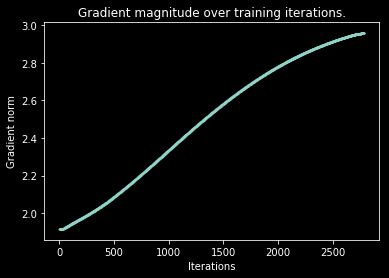

In [150]:
plt.scatter(iteration_vector, gradient_magnitude, s=1)
plt.title('Gradient magnitude over training iterations.')
plt.ylabel('Gradient norm')
plt.xlabel('Iterations')
plt.show()

Let's now visualize the training and validation loss.

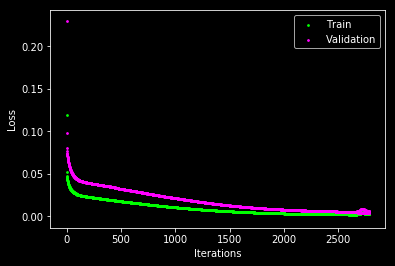

In [151]:
plt.close()
training_loss = mlp_sinc.training_loss
validation_loss = mlp_sinc.validation_loss
plt.scatter(iteration_vector, training_loss, s=3, c='lime', label='Train')
plt.scatter(iteration_vector, validation_loss, s=3, c='fuchsia', label='Validation')
plt.ylabel('Loss')
plt.xlabel('Iterations')
plt.legend(loc='upper right')
plt.show()

Let's try to see learnt function.

In [152]:
x_range = np.arange(-15,15, 0.05)
sinc_out = np.sin(x_range)/x_range
neuralnetwork_out = mlp_sinc.predict(x_range)

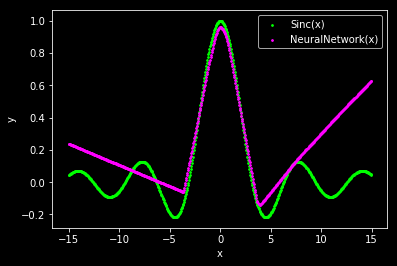

In [153]:
plt.scatter(x_range, sinc_out, s=3, c='lime', label='Sinc(x)')
plt.scatter(x_range, neuralnetwork_out, s=3, c='fuchsia', label='NeuralNetwork(x)')
plt.ylabel('y')
plt.xlabel('x')
plt.legend(loc='upper right')
plt.show()